In [1]:
REALTIME_ESTIMATOR = False
# set the window of blocks, will be overwritten if REALTIME_ESTIMATOR == True
week_1_start_ts = 1590969600
WEEK = 57
week_end_timestamp = week_1_start_ts + WEEK * 7 * 24 * 60 * 60
week_start_timestamp = week_end_timestamp - 7 * 24 * 60 * 60
BAL_addresses = {
    1: '0xba100000625a3754423978a60c9317c58a424e3d',
    137: '0x9a71012b13ca4d3d0cdc72a177df3ef03b0e76a3'
}
networks = {
    1: 'ethereum',
    137: 'polygon'
}
CLAIM_PRECISION = 18 # leave out of results addresses that mined less than CLAIM_THRESHOLD
CLAIM_THRESHOLD = 10**(-CLAIM_PRECISION)
reports_dir = f'reports/{WEEK}'
def get_export_filename(network, token):
    return f'{reports_dir}/__{network}_{token}.json'

In [2]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import warnings
import time
from web3 import Web3
import pandas as pd
from urllib.request import urlopen
import json

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [3]:
if REALTIME_ESTIMATOR:
    warnings.warn('Running realtime estimator')
    
    from urllib.request import urlopen
    import json
    url = 'https://ipfs.fleek.co/ipns/balancer-team-bucket.storage.fleek.co/balancer-claim/snapshot'
    jsonurl = urlopen(url)
    claims = json.loads(jsonurl.read())
    claimable_weeks = [20+int(w) for w in claims.keys()]
    most_recent_week = max(claimable_weeks)
    # delete the estimates for the most recent published week, since now there's an official value available on IPFS
    project_id = os.environ['GCP_PROJECT']
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.lp_estimates_tmp
        WHERE week = {most_recent_week}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result()
    
    
    from datetime import datetime
    week_1_start = '01/06/2020 00:00:00 UTC'
    week_1_start = datetime.strptime(week_1_start, '%d/%m/%Y %H:%M:%S %Z')
    WEEK = int(1 + (datetime.utcnow() - week_1_start).days/7)  # this is what week we're actually in
    week_end_timestamp = week_1_start_ts + WEEK * 7 * 24 * 60 * 60
    week_start_timestamp = week_end_timestamp - 7 * 24 * 60 * 60
    week_end_timestamp = int(datetime.utcnow().timestamp())
    week_passed = (week_end_timestamp - week_start_timestamp)/(7*24*3600)

In [4]:
# get addresses that redirect
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/redirect.json'
    jsonurl = urlopen(url)
    redirects = json.loads(jsonurl.read())
else:
    redirects = json.load(open('config/redirect.json'))

In [5]:
def v2_liquidity_mining(week, 
                        pools_addresses_and_tokens_earned,
                        network):
    
    network_name = networks[network]

    network_blocks_table = {
        1: 'bigquery-public-data.crypto_ethereum.blocks',
        137: 'public-data-finance.crypto_polygon.blocks',
    }

    bpt_balances_table = {
        1: 'blockchain-etl.ethereum_balancer.view_token_balances_subset',
        137: 'blockchain-etl.polygon_balancer.view_bpt_balances',
    }

    with open('src/liquidity_mining_V2.sql','r') as file:
        sql = (
            file
            .read()
            .format(
                week, 
                '\',\''.join(pools_addresses_and_tokens_earned.index),
                network_blocks_table[network],
                bpt_balances_table[network]
            )
        )
    # print(sql)

    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying Bigquery for the V2 LPs...')

    client = bigquery.Client()
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    time_weighted_share = (
        client.query(sql)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')
    time_weighted_share['miner'] = time_weighted_share['miner'].apply(Web3.toChecksumAddress)
    time_weighted_share.set_index(['pool_address','miner'], inplace=True)

    for token in pools_addresses_and_tokens_earned.columns:
        bal_mined_v2 = time_weighted_share['share']*pools_addresses_and_tokens_earned[token]
        # df.mul(time_weighted_share['share'], axis=0)
        
        if REALTIME_ESTIMATOR:
            bal_mined_v2 *= week_passed

        miner_export_v2 = bal_mined_v2.groupby('miner').sum()
        print(f'\n{miner_export_v2.sum()} {token} mined on {network_name}')

        v2_miners = pd.DataFrame(miner_export_v2).reset_index()
        n = len(v2_miners['miner'].drop_duplicates()[v2_miners['miner'].drop_duplicates().isin(redirects.keys())])
        print(f'Redirect: {n} redirectors found')
        v2_miners['miner'] = v2_miners['miner'].apply(lambda x: redirects.get(x,x))
        miner_export_v2 = v2_miners.groupby('miner').sum()[0]

        if not REALTIME_ESTIMATOR:
            filename = get_export_filename(network_name, token)
            (
                miner_export_v2[miner_export_v2>=CLAIM_THRESHOLD]
                .apply(
                    lambda x: format(
                        x, 
                        f'.{CLAIM_PRECISION}f'
                    )
                )
                .to_json(filename, indent=4)
            )

In [6]:
# V2 allocation
V2_LM_ALLOCATION_URL = 'https://raw.githubusercontent.com/balancer-labs/frontend-v2/master/src/lib/utils/liquidityMining/MultiTokenLiquidityMining.json'
jsonurl = urlopen(V2_LM_ALLOCATION_URL)
try:
    V2_ALLOCATION_THIS_WEEK = json.loads(jsonurl.read())[f'week_{WEEK}']
except KeyError:
    V2_ALLOCATION_THIS_WEEK = {}
for chain in V2_ALLOCATION_THIS_WEEK:
    print('\nChain: {}'.format(chain['chainId']))
    df = pd.DataFrame()
    for pool,rewards in chain['pools'].items():
        for r in rewards:
            pool_address = pool[:42].lower()
            df.loc[pool_address,r['tokenAddress']] = r['amount']
    df.fillna(0, inplace=True)
    df.index.name = 'pool_address'
    print('BAL to be mined on this chain: {}'.format(df[BAL_addresses[chain['chainId']]].sum()))
    v2_liquidity_mining(WEEK, df, chain['chainId'])


Chain: 1
BAL to be mined on this chain: 123500.0
2021-06-30 22:48:07 - Querying Bigquery for the V2 LPs...
2021-06-30 22:48:40 - Done!

123500.00000000001 0xba100000625a3754423978a60c9317c58a424e3d mined on ethereum
Redirect: 0 redirectors found

Chain: 137
BAL to be mined on this chain: 21500.0
2021-06-30 22:48:40 - Querying Bigquery for the V2 LPs...
2021-06-30 22:49:18 - Done!

21500.000000000022 0x9a71012b13ca4d3d0cdc72a177df3ef03b0e76a3 mined on polygon
Redirect: 0 redirectors found

375000.00000000023 0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270 mined on polygon
Redirect: 0 redirectors found

15000.000000000104 0x580a84c73811e1839f75d86d75d88cca0c241ff4 mined on polygon
Redirect: 0 redirectors found


In [7]:
week = 57
network = 137 
network_name = networks[network]

network_blocks_table = {
    1: 'bigquery-public-data.crypto_ethereum.blocks',
    137: 'public-data-finance.crypto_polygon.blocks',
}

bpt_balances_table = {
    1: 'blockchain-etl.ethereum_balancer.view_token_balances_subset',
    137: 'blockchain-etl.polygon_balancer.view_bpt_balances',
}

with open('src/liquidity_mining_V2.sql','r') as file:
    sql = (
        file
        .read()
        .format(
            week, 
            '\',\''.join(df.index),
            network_blocks_table[network],
            bpt_balances_table[network]
        )
    )
# print(sql)

print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying Bigquery for the V2 LPs...')

client = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()
time_weighted_share = (
    client.query(sql)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')
time_weighted_share['miner'] = time_weighted_share['miner'].apply(Web3.toChecksumAddress)
time_weighted_share.set_index(['pool_address','miner'], inplace=True)


2021-06-30 22:49:18 - Querying Bigquery for the V2 LPs...
2021-06-30 22:49:55 - Done!


In [8]:
mainnet_BAL = pd.read_json(
    get_export_filename(networks[1], BAL_addresses[1]), 
    typ='series', 
    convert_dates=False)

polygon_BAL = pd.read_json(
    get_export_filename(networks[137], BAL_addresses[137]), 
    typ='series', 
    convert_dates=False)

mined_BAL = mainnet_BAL.add(polygon_BAL, fill_value=0)

if not REALTIME_ESTIMATOR:
    filename = '/_totalsLiquidityMining.json'
    (
        mined_BAL[mined_BAL>=CLAIM_THRESHOLD]
        .apply(
            lambda x: format(
                x, 
                f'.{CLAIM_PRECISION}f'
            )
        )
        .to_json(reports_dir+filename, indent=4)
    )
    print('Total BAL mined: {}'.format(mined_BAL.sum()))

Total BAL mined: 145000.00000000003


# Update real time estimates in GBQ

In [9]:
if REALTIME_ESTIMATOR:
    sql = f'''
        UPDATE {project_id}.bal_mining_estimates.lp_estimates_tmp
        SET velocity = '0'
        WHERE week = {WEEK-1}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();

    # write to GBQ (LPs)
    cur_estimate = pd.DataFrame(mainnet_BAL)
    cur_estimate.columns = ['earned']
    cur_estimate.index.name = 'address'
    
    try:
        prev_estimate = pd.read_gbq(f'select address, earned, timestamp from bal_mining_estimates.lp_estimates_tmp WHERE week = {WEEK}', 
                        project_id=os.environ['GCP_PROJECT'])
        prev_estimate.set_index('address', inplace=True)
        prev_estimate_timestamp = prev_estimate.iloc[0]['timestamp']
    except:
        prev_estimate_timestamp = 0
    if prev_estimate_timestamp < week_start_timestamp:
        #previous estimate is last week's; compute velocity from end_block_timestamp and start_block_timestamp
        delta_t = (week_end_timestamp - week_start_timestamp)
        earned = cur_estimate['earned'].astype(float)
        cur_estimate['velocity'] = (earned/delta_t).apply(lambda x: format(x, f'.{18}f'))
    else:
        #compute velocity based on increase and time passed
        delta_t = (week_end_timestamp - prev_estimate_timestamp)
        diff_estimate = cur_estimate.join(prev_estimate, rsuffix='_prev').fillna(0)
        cur_earned = diff_estimate['earned'].astype(float)
        prev_earned = diff_estimate['earned_prev'].astype(float)
        cur_estimate['velocity'] = ((cur_earned-prev_earned)/delta_t).apply(lambda x: format(x, f'.{18}f'))
        
    # delete this week's previous estimates
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.lp_estimates_tmp
        WHERE week = {WEEK}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();

    cur_estimate['earned'] = cur_estimate['earned'].apply(lambda x: format(x, f'.{18}f'))
    cur_estimate['timestamp'] = week_end_timestamp
    cur_estimate['week'] = WEEK
    cur_estimate.reset_index(inplace=True)
    cur_estimate.to_gbq( 'bal_mining_estimates.lp_estimates_tmp', 
                        project_id=os.environ['GCP_PROJECT'], 
                        if_exists='append')

# Gas Reimbursement Program

2021-06-30 22:49:56 - Querying Bigquery for eligible V1 swaps and reimbursement values ...
2021-06-30 22:50:14 - Done!


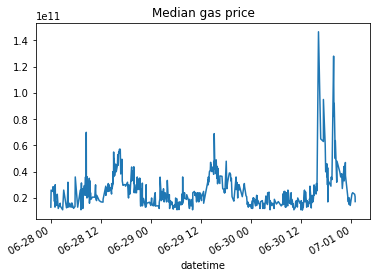

ETH reimbursements for the week (V1): 2.317562304326932


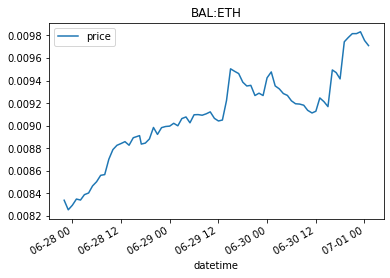

BAL reimbursements for the week (V1): 254.1038354060567
2021-06-30 22:50:15 - Querying Bigquery for eligible V2 swaps and reimbursement values ...
2021-06-30 22:50:27 - Done!


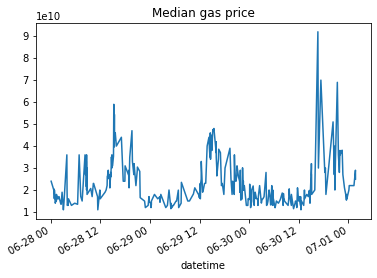

ETH reimbursements for the week (V2): 0.8419994487291104


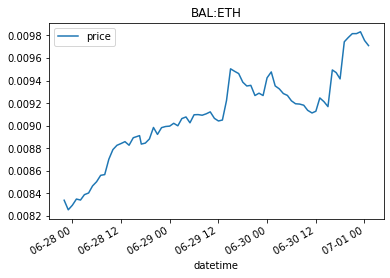

BAL reimbursements for the week (V2): 92.15655604484758


In [10]:
from src.bal4gas_V1 import compute_bal_for_gas as compute_bal_for_gas_V1
from src.bal4gas_V2 import compute_bal_for_gas as compute_bal_for_gas_V2

if not REALTIME_ESTIMATOR:
    whitelist = pd.read_json(f'https://raw.githubusercontent.com/balancer-labs/assets/w{WEEK-1}/lists/eligible.json').index.values
    gas_whitelist = pd.Series(whitelist).str.lower().tolist()
    gas_whitelist.append('0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee')

    
    v1 = compute_bal_for_gas_V1(week_start_timestamp, week_end_timestamp, gas_whitelist, plot=True, verbose=True)

    gas_whitelist.remove('0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee')
    gas_whitelist.append('0x0000000000000000000000000000000000000000')
    v2 = compute_bal_for_gas_V2(week_start_timestamp, week_end_timestamp, gas_whitelist, plot=True, verbose=True)
    
    merge = v1.append(v2)

    totals_bal4gas = merge[['address','bal_reimbursement']].groupby('address').sum()['bal_reimbursement']
    totals_bal4gas[totals_bal4gas>=CLAIM_THRESHOLD].apply(\
       lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_gasReimbursement.json',
       indent=4)

    # combine BAL from liquidity mining and gas reimbursements
    totals = mainnet_BAL.add(totals_bal4gas, fill_value=0)
    totals[totals>=CLAIM_THRESHOLD].apply(\
       lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_totals.json',
       indent=4)

In [11]:
if not REALTIME_ESTIMATOR:
    print('Final Check Totals BAL')
    
    
    _ethereum = pd.read_json(
        get_export_filename(networks[1], BAL_addresses[1]), 
        typ='series', 
        convert_dates=False).sum()

    _polygon = pd.read_json(
        get_export_filename(networks[137], BAL_addresses[137]), 
        typ='series', 
        convert_dates=False).sum()
    
    
    _lm_both = pd.read_json(reports_dir+'/_totalsLiquidityMining.json', orient='index').sum().values[0]
    _claim = pd.read_json(reports_dir+'/_totals.json', orient='index').sum().values[0]
    print(f'Liquidity Mining Ethereum: {format(_ethereum, f".{CLAIM_PRECISION}f")}')
    print(f'Liquidity Mining Polygon: {format(_polygon, f".{CLAIM_PRECISION}f")}')
    print(f'Liquidity Mining Both: {format(_lm_both, f".{CLAIM_PRECISION}f")}')
    print(f'Gas Reimbursement week {WEEK}: {format(_claim-_ethereum, f".{CLAIM_PRECISION}f")}')
    print(f'Claims: {format(_claim, f".{CLAIM_PRECISION}f")}')

Final Check Totals BAL
Liquidity Mining Ethereum: 123500.000000000014551915
Liquidity Mining Polygon: 21500.000000000021827873
Liquidity Mining Both: 145000.000000000029103830
Gas Reimbursement week 57: 346.260391450894530863
Claims: 123846.260391450909082778
